In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

import cv2

In [3]:
DATASET_PATH = '/content/drive/MyDrive/dcx_mid_project/Project_Folder/data_set'
FOOD_CLASSES = ['감자', '계란','고추', '당근','대파','마늘', '무', '배추', '양파']
IMG_SIZE = (224, 224)
BATCH_SIZE = 128

In [4]:
def resize_image(img):
    img_resized = cv2.resize(img, IMG_SIZE)
    return img_resized

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=resize_image,  # 이미지 resize 함수를 preprocessing_function 인자로 추가
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)
train_generator.n

Found 1667 images belonging to 9 classes.


1667

In [6]:
# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     preprocessing_function=resize_image,
#     validation_split=0.2)

val_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    subset='validation'
)

Found 414 images belonging to 9 classes.


In [ ]:
# def build_vgg_block(input_layer,
#                     num_cnn=3, 
#                     channel=64,
#                     block_num=1,
#                    ):                   
#     # 입력 레이어
#     x = input_layer
# 	# num_cnn : 한블럭에서 사용할 conv필터 개수 네트워크에 따라 2개일때가 있고 3개일때가 있음.
#     # CNN 레이어
#     for cnn_num in range(num_cnn):
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(3,3),
#             activation='relu',
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_conv{cnn_num}'
#         )(x)    

#     # Max Pooling 레이어
#     x = keras.layers.MaxPooling2D(
#         pool_size=(2, 2),
#         strides=2,
#         name=f'block{block_num}_pooling'
#     )(x)

#     return x

In [ ]:
# def build_vgg(input_shape=(32,32,3),
#               num_cnn_list=[2,2,3,3,3],
#               channel_list=[64,128,256,512,512],
#               num_classes=10):
    
#     assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    
    
    
#     input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
#     output = input_layer
    
#     # config list들의 길이만큼 반복해서 블록을 생성합니다.
#     for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
#         output = build_vgg_block(
#             output,
#             num_cnn=num_cnn, 
#             channel=channel,
#             block_num=i
#         )
        
#     output = keras.layers.Flatten(name='flatten')(output)
#     output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
#     output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
#     output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
#     model = keras.Model(
#         inputs=input_layer, 
#         outputs=output
#     )
#     return model

In [7]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = vgg16.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(FOOD_CLASSES), activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=predictions)

58889256/58889256 [==============================] - 2s 0us/step


In [8]:
for layer in vgg16.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=4)
mc = ModelCheckpoint('/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/best_model_base_vgg16.h5', monitor='val_accuracy', mode='max', verbose=2, save_best_only=True)

In [10]:
EPOCHS = 100
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

history = model.fit(train_generator, epochs=EPOCHS, steps_per_epoch=STEP_SIZE_TRAIN, callbacks=[es,mc], validation_data=val_generator)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


13/13 [==============================] - ETA: 0s - loss: 10.5035 - accuracy: 0.2528  
Epoch 1: val_accuracy improved from -inf to 0.47826, saving model to /content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/best_model_base_vgg16.h5
13/13 [==============================] - 1465s 110s/step - loss: 10.5035 - accuracy: 0.2528 - val_loss: 5.0390 - val_accuracy: 0.4783
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 2.3804 - accuracy: 0.4951  
Epoch 2: val_accuracy improved from 0.47826 to 0.68357, saving model to /content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/best_model_base_vgg16.h5
13/13 [==============================] - 1354s 105s/step - loss: 2.3804 - accuracy: 0.4951 - val_loss: 0.9937 - val_accuracy: 0.6836
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.9823 - accuracy: 0.6654  
Epoch 3: val_accuracy improved from 0.68357 to 0.70773, saving model to /content/drive/MyDrive/dcx_mid_project

In [12]:
model.save('/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/base_vgg16.h5')

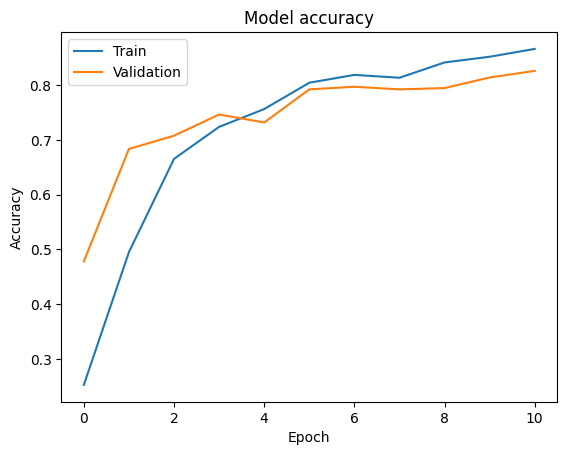

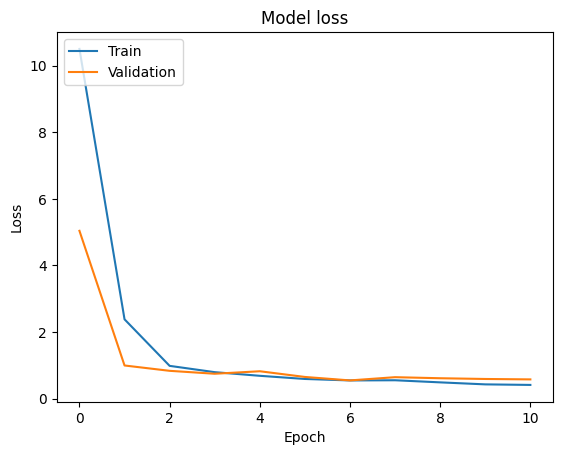

In [13]:
# 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=resize_image  # 이미지 resize 함수를 preprocessing_function 인자로 추가
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

In [ ]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

scores = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print(f'Test loss: {scores[0]}')
print(f'Test accuracy: {scores[1]}')

model.save('/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/base_vgg16.h5')

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model

# 사전 학습된 모델 불러오기
input_tensor = Input(shape=(244,244,3))
model = VGG16(weights='imagenet', include_top=False, input_tensor = input_tensor)

In [ ]:
# 모델 Layer 데이터화
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Layer 추가
x = layer_dict['block5_pool'].output
# Cov2D Layer +
x = Conv2D(filters = 64, kernel_size=(3, 3), activation='relu')(x)
# MaxPooling2D Layer +
x = MaxPooling2D(pool_size=(2, 2))(x)
# Flatten Layer +
x = Flatten()(x)
# FC Layer +
x = Dense(2048, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)

# new model 정의
new_model = Model(inputs = model.input, outputs = x)

In [ ]:
# CNN Pre-trained 가중치를 그대로 사용할때
for layer in new_model.layers[:19] :
    layer.trainable = False

new_model.summary()

# 컴파일 옵션
new_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

In [ ]:
# 모델 학습
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
history = new_model.fit(train_generator, epochs=5, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_generator)

In [ ]:
new_model.save("/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/add_layer_vgg16.h5")                        
                        
# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

In [ ]:
# ResNet50 불러오기 -> include_top = False로 바꾸는 것이 포인트
base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3), weights = 'imagenet')
base_model.trainable = False

inputs = Input(shape=(224,224,3))
x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training = False)
x = Flatten()(x)								# Fully Connected에 온전하게 학습을 위해 펼쳐준다	
outputs = Dense(9, activation = 'softmax')(x)	# Softmax 함수로 10개 분류하는 분류기 
model_res = tf.keras.Model(inputs, outputs)
model_res.summary()

In [ ]:
# 모델 컴파일 진행 - 아까와 달리 categorical_crossentropy 사용 > label이 숫자형 데이터이므로
model_res.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
# early stopping 설정
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 모델 fitting
history = model_res.fit(train_generator, epochs = 5, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=val_generator, callbacks=[early])

In [ ]:
model_res.save("/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/res50.h5")    

# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras import regularizers

In [ ]:
# input shape, classes 개수, kernel_regularizer등을 인자로 가져감. 
def create_alexnet(in_shape=(227, 227, 3), n_classes=10, kernel_regular=None):
    # 첫번째 CNN->ReLU->MaxPool, kernel_size를 매우 크게 가져감(11, 11)
    input_tensor = Input(shape=in_shape)
    
    x = Conv2D(filters= 96, kernel_size=(11,11), strides=(4,4), padding='valid')(input_tensor)
    x = Activation('relu')(x)
    # LRN을 대신하여 Batch Normalization 적용. 
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)


    # 두번째 CNN->ReLU->MaxPool. kernel_size=(5, 5)
    x = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same',kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)


    # 3x3 Conv 2번 연속 적용. filters는 384개
    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # 3x3 Conv를 적용하되 filters 수를 줄이고 maxpooling을 적용
    x = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=kernel_regular)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

    # Dense 연결을 위한 Flatten
    x = Flatten()(x)

    # Dense + Dropout을 연속 적용. 
    x = Dense(units = 4096, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(units = 4096, activation = 'relu')(x)
    x = Dropout(0.5)(x)

    # 마지막 softmax 층 적용. 
    output = Dense(units = n_classes, activation = 'softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()
    
    return model

In [ ]:
model = create_alexnet(in_shape=(224, 224, 3), n_classes=9)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

history = model.fit(train_generator, epochs=5, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator, 
                    #validation_steps=int(np.ceil(val_images.shape[0]/BATCH_SIZE)), 
                    callbacks=[rlr_cb, ely_cb]
                   )

In [ ]:
model_res.save("/content/drive/MyDrive/dcx_mid_project/DCX_Mid_Project/learning_code/models/alexnet.h5")    

# 최종 결과 리포트
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

from matplotlib import pyplot as plt

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='testing acc')
plt.title('Training and testing accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='testing loss')
plt.title('Training and testing loss')
plt.legend()

plt.show()
